In [6]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def schema_convert(df):
    schema_dict = {'A':str, 'B':int,'C':float,}
    df = pd.DataFrame({'A':['area_fips','own_code','industry_code','agglvl_code','size_code','year','qtr','disclosure_code','area_title','own_title','industry_title','agglvl_title','size_title','lq_disclosure_code','oty_disclosure_code'],'B':['qtrly_estabs_count','month1_emplvl','month2_emplvl','month3_emplvl','total_qtrly_wages', 'taxable_qtrly_wages','qtrly_contributions','avg_weekly_wage','oty_qtrly_estabs_count_chg','oty_month1_emplvl_chg','oty_month2_emplvl_chg','oty_month3_emplvl_chg','oty_total_qtrly_wages_chg','oty_taxable_qtrly_wages_chg','oty_qtrly_contributions_chg','oty_avg_wkly_wage_chg',],'C':['lq_qtrly_estabs_count','lq_month1_emplvl','lq_month2_emplvl','lq_month3_emplvl','lq_total_qtrly_wages','lq_taxable_qtrly_wages','lq_qtrly_contributions','lq_avg_wkly_wage','oty_qtrly_estabs_count_pct_chg','oty_month1_emplvl_pct_chg','oty_month3_emplvl_pct_chg','oty_month2_emplvl_pct_chg','oty_total_qtrly_wages_pct_chg','oty_taxable_qtrly_wages_pct_chg','oty_qtrly_contributions_pct_chg','oty_avg_wkly_wage_pct_chg']})
    for col, col_type in schema_dict.items():
        df[col] = df[col].astype(col_type)
    return df

In [4]:
qcew2007_df = pd.read_csv('data/2007.q1-q4.singlefile.csv')

/home/jc/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,7,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


MemoryError: Unable to allocate 2.26 GiB for an array with shape (21, 14438464) and data type int64

Too much data for a pandas (duh). Also some inconsistent data types in some columns.

In [11]:
qcew2007_df = pd.read_csv('data/2007.q1.by_size.csv', dtype = {'area_fips':str})
qcew2007_df.head()

,area_fips,own_code,industry_code,agglvl_code,size_code,year,qtr,disclosure_code,area_title,own_title,...,oty_month3_emplvl_chg,oty_month3_emplvl_pct_chg,oty_total_qtrly_wages_chg,oty_total_qtrly_wages_pct_chg,oty_taxable_qtrly_wages_chg,oty_taxable_qtrly_wages_pct_chg,oty_qtrly_contributions_chg,oty_qtrly_contributions_pct_chg,oty_avg_wkly_wage_chg,oty_avg_wkly_wage_pct_chg
0,US000,5,10,21,1,2007,1,NaN,U.S. TOTAL,Private,...,130188,1.7,4839069335,6.7,2024330138,4.4,-21861828,-2.0,34,4.8
1,US000,5,10,21,2,2007,1,NaN,U.S. TOTAL,Private,...,107456,1.2,4162656328,5.5,1726937812,3.4,-57070246,-4.5,27,4.2
2,US000,5,10,21,3,2007,1,NaN,U.S. TOTAL,Private,...,203592,1.6,6732691796,6.3,2596666663,3.8,-86405295,-4.8,30,4.4
3,US000,5,10,21,4,2007,1,NaN,U.S. TOTAL,Private,...,371159,1.9,11415214806,6.5,4419846197,4.1,-171282542,-5.6,31,4.3
4,US000,5,10,21,5,2007,1,NaN,U.S. TOTAL,Private,...,252553,1.7,9413557660,6.3,3324786274,3.8,-159111463,-6.1,35,4.5


qcew2007_df = pd.read_csv('data/2007.q1-q4.singlefile.csv')

And that crashed my machine. If I'm going to work with this much data, I'm going to need to make use of Spark/AWS in order to crunch these numbers. Let's proceed with the single quarter's worth of data.

In [12]:
qcew2007_df.info() 
qcew2007_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33069 entries, 0 to 33068
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   area_fips                        33069 non-null  object 
 1   own_code                         33069 non-null  int64  
 2   industry_code                    33069 non-null  object 
 3   agglvl_code                      33069 non-null  int64  
 4   size_code                        33069 non-null  int64  
 5   year                             33069 non-null  int64  
 6   qtr                              33069 non-null  int64  
 7   disclosure_code                  6280 non-null   object 
 8   area_title                       33069 non-null  object 
 9   own_title                        33069 non-null  object 
 10  industry_title                   33069 non-null  object 
 11  agglvl_title                     33069 non-null  object 
 12  size_title        

,own_code,agglvl_code,size_code,year,qtr,qtrly_estabs_count,month1_emplvl,month2_emplvl,month3_emplvl,total_qtrly_wages,...,oty_month3_emplvl_chg,oty_month3_emplvl_pct_chg,oty_total_qtrly_wages_chg,oty_total_qtrly_wages_pct_chg,oty_taxable_qtrly_wages_chg,oty_taxable_qtrly_wages_pct_chg,oty_qtrly_contributions_chg,oty_qtrly_contributions_pct_chg,oty_avg_wkly_wage_chg,oty_avg_wkly_wage_pct_chg
count,33069.0,33069.00000,33069.000000,33069.0,33069.0,3.306900e+04,3.306900e+04,3.306900e+04,3.306900e+04,3.306900e+04,...,33069.000000,33069.000000,3.306900e+04,33069.000000,3.306900e+04,33069.000000,3.306900e+04,33069.000000,33069.000000,33069.000000
mean,5.0,42.89534,4.677674,2007.0,1.0,3.118497e+03,3.969135e+04,3.977614e+04,4.016837e+04,4.592464e+08,...,582.711452,2.255112,2.914214e+07,6.438813,8.278363e+06,4.558925,-3.934653e+05,-1.682905,35.408812,3.797366
std,0.0,17.97468,2.470005,0.0,0.0,4.474041e+04,3.111426e+05,3.120937e+05,3.155933e+05,3.638915e+09,...,6361.030934,41.623571,2.720685e+08,46.763344,7.033916e+07,41.090503,3.508390e+06,46.069084,227.469651,14.358589
min,5.0,21.00000,1.000000,2007.0,1.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-76865.000000,-92.100000,-1.088329e+09,-91.500000,-3.029762e+08,-100.000000,-2.284795e+08,-100.000000,-4285.000000,-78.700000
25%,5.0,27.00000,3.000000,2007.0,1.0,1.800000e+01,5.860000e+02,5.800000e+02,5.860000e+02,5.637799e+06,...,-58.000000,-1.200000,0.000000e+00,0.000000,0.000000e+00,0.000000,-1.873750e+05,-10.700000,0.000000,0.000000
50%,5.0,28.00000,5.000000,2007.0,1.0,1.130000e+02,5.087000e+03,5.105000e+03,5.135000e+03,5.219520e+07,...,0.000000,0.000000,9.390700e+05,2.600000,2.545920e+05,1.100000,-4.940000e+03,-1.000000,13.000000,2.200000
75%,5.0,64.00000,7.000000,2007.0,1.0,7.640000e+02,1.961600e+04,1.959100e+04,1.978400e+04,2.098292e+08,...,365.000000,4.000000,1.082395e+07,9.200000,4.544858e+06,6.900000,0.000000e+00,0.000000,44.000000,5.900000
max,5.0,64.00000,9.000000,2007.0,1.0,5.189837e+06,1.918108e+07,1.925676e+07,1.956681e+07,2.153183e+11,...,371159.000000,2758.200000,1.581241e+10,2481.900000,4.419846e+09,2013.800000,3.774437e+07,2179.400000,14454.000000,1047.800000


The data seems *very* clean (yes gov't does good work sometimes. There's a good amount of columns that we *don't* need, but we'll worry about them later. Let's do some basic charts to get a feel for the data.

In [21]:
tempdf = qcew2007_df.filter(['oty_avg_wkly_wage_chg'], axis = 1)
#plt.hist(qcew2007_df, column = 'oty_avg_wkly_wage_chg', bins=50) I don't know why this is bugging out on me

([array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0.

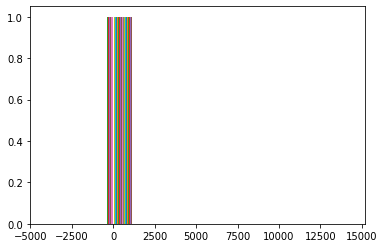

In [22]:
plt.hist(tempdf)
#I don't know why this isn't plotting. I will need assistance.